# Reporte de Analítica

## Importar modulos

In [392]:
import zipfile
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [210]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Recopilación de los datos

## Recopilar datos
Usar Kaggle API para obtener el dataset

In [211]:
!kaggle datasets download marianarfranklin/mexico-covid19-clinical-data

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


## Organizar y almacenar
Descomprimir archivo zip y guardar el archivo csv

In [212]:
with zipfile.ZipFile('mexico-covid19-clinical-data.zip', 'r') as zip_ref:
    zip_ref.extractall('')

## Preprocesamiento
Limpieza de datos

In [213]:
df = pd.read_csv('mexico_covid19.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263007 entries, 0 to 263006
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   263007 non-null  int64  
 1   FECHA_ARCHIVO        263007 non-null  object 
 2   ID_REGISTRO          263007 non-null  object 
 3   ENTIDAD_UM           263007 non-null  int64  
 4   ENTIDAD_RES          263007 non-null  int64  
 5   RESULTADO            263007 non-null  int64  
 6   DELAY                263007 non-null  int64  
 7   ENTIDAD_REGISTRO     263007 non-null  int64  
 8   ENTIDAD              263007 non-null  object 
 9   ABR_ENT              263007 non-null  object 
 10  FECHA_ACTUALIZACION  263007 non-null  object 
 11  ORIGEN               263007 non-null  int64  
 12  SECTOR               263007 non-null  int64  
 13  SEXO                 263007 non-null  int64  
 14  ENTIDAD_NAC          263007 non-null  int64  
 15  MUNICIPIO_RES    

### Remover columnas innecesarias

In [214]:
df_clean = df.drop(columns = ['id', 'ID_REGISTRO', 'DELAY'], inplace=False)
df_clean.head()

,FECHA_ARCHIVO,ENTIDAD_UM,ENTIDAD_RES,RESULTADO,ENTIDAD_REGISTRO,ENTIDAD,ABR_ENT,FECHA_ACTUALIZACION,ORIGEN,SECTOR,...,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-04-12,25,25,2,25,Sinaloa,SL,2020-04-19,2,12,...,2,2,1,2,2,2,99,MÃ©xico,97,97
1,2020-04-12,14,14,2,14,Jalisco,JC,2020-04-19,1,4,...,2,2,1,2,1,99,99,MÃ©xico,97,2
2,2020-04-12,8,8,1,8,Chihuahua,CH,2020-04-19,1,4,...,2,2,2,2,2,99,99,MÃ©xico,97,2
3,2020-04-12,9,15,1,9,Ciudad de Mexico,DF,2020-04-19,2,4,...,2,2,1,2,2,99,99,MÃ©xico,97,97
4,2020-04-12,9,9,2,9,Ciudad de Mexico,DF,2020-04-19,1,4,...,2,2,2,2,2,99,99,MÃ©xico,97,97


### Convertir atributos de tipo objeto a tipo datetime

In [215]:
# The attributes in the list are object type, so we convert each into a datetime type attribute
# FECHA_DEF cannot be coverted into datetime format becasue 9999-99-99 ins't a valid a date, so we replace it with 2200-01-01 which is  valir format and still is outlier.
df_clean['FECHA_DEF'] = df_clean['FECHA_DEF'].replace('9999-99-99', '2200-01-01')


# The attributes in the following list are object type, so we convert each into a datetime type attribute
tipos_de_fechas = ['FECHA_ARCHIVO', 'FECHA_ACTUALIZACION', 'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF']
for tipo_de_fecha in tipos_de_fechas:
    df_clean[tipo_de_fecha] = pd.to_datetime(df_clean[tipo_de_fecha])

In [216]:
df_clean.head()

,FECHA_ARCHIVO,ENTIDAD_UM,ENTIDAD_RES,RESULTADO,ENTIDAD_REGISTRO,ENTIDAD,ABR_ENT,FECHA_ACTUALIZACION,ORIGEN,SECTOR,...,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-04-12,25,25,2,25,Sinaloa,SL,2020-04-19,2,12,...,2,2,1,2,2,2,99,MÃ©xico,97,97
1,2020-04-12,14,14,2,14,Jalisco,JC,2020-04-19,1,4,...,2,2,1,2,1,99,99,MÃ©xico,97,2
2,2020-04-12,8,8,1,8,Chihuahua,CH,2020-04-19,1,4,...,2,2,2,2,2,99,99,MÃ©xico,97,2
3,2020-04-12,9,15,1,9,Ciudad de Mexico,DF,2020-04-19,2,4,...,2,2,1,2,2,99,99,MÃ©xico,97,97
4,2020-04-12,9,9,2,9,Ciudad de Mexico,DF,2020-04-19,1,4,...,2,2,2,2,2,99,99,MÃ©xico,97,97


In [217]:
df_clean['EMBARAZO'].value_counts()

97    134310
2     126077
1       2064
98       556
Name: EMBARAZO, dtype: int64

# EDA - Análisis Exploratorio de los datos

## Resumen estadística
Calcular estadística descriptiva -> promedio, media, desviación estándar, mínimo, máximo, percentiles, etc.

In [218]:
df_clean.describe()

,ENTIDAD_UM,ENTIDAD_RES,RESULTADO,ENTIDAD_REGISTRO,ORIGEN,SECTOR,SEXO,ENTIDAD_NAC,MUNICIPIO_RES,TIPO_PACIENTE,...,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,MIGRANTE,UCI
count,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263001.000000,263007.000000,...,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000
mean,14.844601,15.127719,1.609672,15.092271,1.635789,9.601680,1.510682,19.691004,36.441401,1.236378,...,2.359667,2.174185,2.453961,2.324980,2.184763,2.320231,2.268217,32.283764,98.593680,74.541012
std,8.001043,7.904314,0.487825,7.915406,0.481209,7.265468,0.499887,19.378113,48.117024,0.424858,...,6.021830,5.745114,6.850231,5.796086,5.817362,5.722995,5.867586,45.350310,6.275497,40.384991
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,9.000000,9.000000,1.000000,9.000000,1.000000,4.000000,1.000000,9.000000,7.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,99.000000,97.000000
50%,14.000000,15.000000,2.000000,15.000000,2.000000,12.000000,2.000000,15.000000,19.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,97.000000
75%,21.000000,21.000000,2.000000,21.000000,2.000000,12.000000,2.000000,24.000000,48.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,99.000000,97.000000
max,32.000000,32.000000,2.000000,32.000000,2.000000,99.000000,2.000000,99.000000,999.000000,2.000000,...,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,99.000000,99.000000,99.000000


## Visualización de los datos
Usar técnicas de visualización como histogramas, gráficas de dispresión, gráficas de barras, diagramas de cajas, entre otros.

### Funcion pastel

In [219]:
# Funcion para automatizar el despliegue de graficas de pastel
def grafica_pastel(atributo, titulo = 'Grafica pastel', diccionario = None, explode=(0.0,.1, 0.1), colors = [(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)]):
    if diccionario == None:
        dictionary = {1: "SI",
                      2: "NO",
                      97: "NO APLICA",
                      98: "SE IGNORA",
                      99: "NO ESPECIFICA"}
    else:
        dictionary = diccionario
    
    value_counts = pd.Series([dictionary[item] for item in df_clean[atributo]]).value_counts()
    
    labels = [key + ': ' + str(value) for key, value in zip(value_counts.index.tolist(), value_counts.values.tolist())]
    
    plt.pie(value_counts,
            labels = labels,
            explode=explode,
            colors = colors,
            autopct='%1.1f%%')
    plt.title(titulo);

In [220]:
df_clean.head()

,FECHA_ARCHIVO,ENTIDAD_UM,ENTIDAD_RES,RESULTADO,ENTIDAD_REGISTRO,ENTIDAD,ABR_ENT,FECHA_ACTUALIZACION,ORIGEN,SECTOR,...,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-04-12,25,25,2,25,Sinaloa,SL,2020-04-19,2,12,...,2,2,1,2,2,2,99,MÃ©xico,97,97
1,2020-04-12,14,14,2,14,Jalisco,JC,2020-04-19,1,4,...,2,2,1,2,1,99,99,MÃ©xico,97,2
2,2020-04-12,8,8,1,8,Chihuahua,CH,2020-04-19,1,4,...,2,2,2,2,2,99,99,MÃ©xico,97,2
3,2020-04-12,9,15,1,9,Ciudad de Mexico,DF,2020-04-19,2,4,...,2,2,1,2,2,99,99,MÃ©xico,97,97
4,2020-04-12,9,9,2,9,Ciudad de Mexico,DF,2020-04-19,1,4,...,2,2,2,2,2,99,99,MÃ©xico,97,97


### ENTIDAD - Estado de referencia

In [221]:
ENTIDAD_NAC = {
    1: 'AGUASCALIENTES',
    2: 'BAJA CALIFORNIA',
    3: 'BAJA CALIFORNIA SUR',
    4: 'CAMPECHE',
    5: 'COAHUILA DE ZARAGOZA',
    6: 'COLIMA',
    7: 'CHIAPAS',
    8: 'CHIHUAHUA',
    9: 'CIUDAD DE MÉXICO',
    10: 'DURANGO',
    11: 'GUANAJUATO',
    12: 'GUERRERO',
    13: 'HIDALGO',
    14: 'JALISCO',
    15: 'MÉXICO',
    16: 'MICHOACÁN DE OCAMPO',
    17: 'MORELOS',
    18: 'NAYARIT',
    19: 'NUEVO LEÓN',
    20: 'OAXACA',
    21: 'PUEBLA',
    22: 'QUERÉTARO',
    23: 'QUINTANA ROO',
    24: 'SAN LUIS POTOSÍ',
    25: 'SINALOA',
    26: 'SONORA',
    27: 'TABASCO',
    28: 'TAMAULIPAS',
    29: 'TLAXCALA',
    30: 'VERACRUZ DE IGNACIO DE LA LLAVE',
    31: 'YUCATÁN',
    32: 'ZACATECAS',
    99: '----NO ESPECIFICADO----'
}

# https://cuentame.inegi.org.mx/monografias/default.aspx?tema=me
datos_poblacion = {
    1: 1425607,
    2: 3769020,
    3: 798447,
    4: 928363,
    5: 3146771,
    6: 731391,
    7: 5543828,
    8: 3741869,
    9: 9209944,
    10: 1832650,
    11: 6166934,
    12: 3540685,
    13: 3082841,
    14: 8348151,
    15: 16992418,
    16: 4748846,
    17: 1971520,
    18: 1235456,
    19: 5784442,
    20: 4132148,
    21: 6583278,
    22: 2368467,
    23: 1857985,
    24: 2822255,
    25: 3026943,
    26: 2944840,
    27: 2402598,
    28: 3527735,
    29: 1342977,
    30: 8062579,
    31: 2320898,
    32: 1622138,
    99:10000000,
}

In [222]:
df_entidad = pd.DataFrame()
df_entidad['codigo'] = ENTIDAD_NAC.keys()
df_entidad['ENTIDAD'] = ENTIDAD_NAC.values()
df_entidad['POBLACION'] = datos_poblacion.values()

pacientes_por_entidad = df_clean['ENTIDAD_NAC'].value_counts()
df_entidad['cant_pacientes'] = [pacientes_por_entidad[codigo] for codigo in df_entidad['codigo']]
df_entidad['cant_pacientes_normalizada'] = round((df_entidad['cant_pacientes']/df_entidad['POBLACION'])*100, 2)
df_entidad.head()

,codigo,ENTIDAD,POBLACION,cant_pacientes,cant_pacientes_normalizada
0,1,AGUASCALIENTES,1425607,4067,0.29
1,2,BAJA CALIFORNIA,3769020,5274,0.14
2,3,BAJA CALIFORNIA SUR,798447,1350,0.17
3,4,CAMPECHE,928363,1434,0.15
4,5,COAHUILA DE ZARAGOZA,3146771,7441,0.24


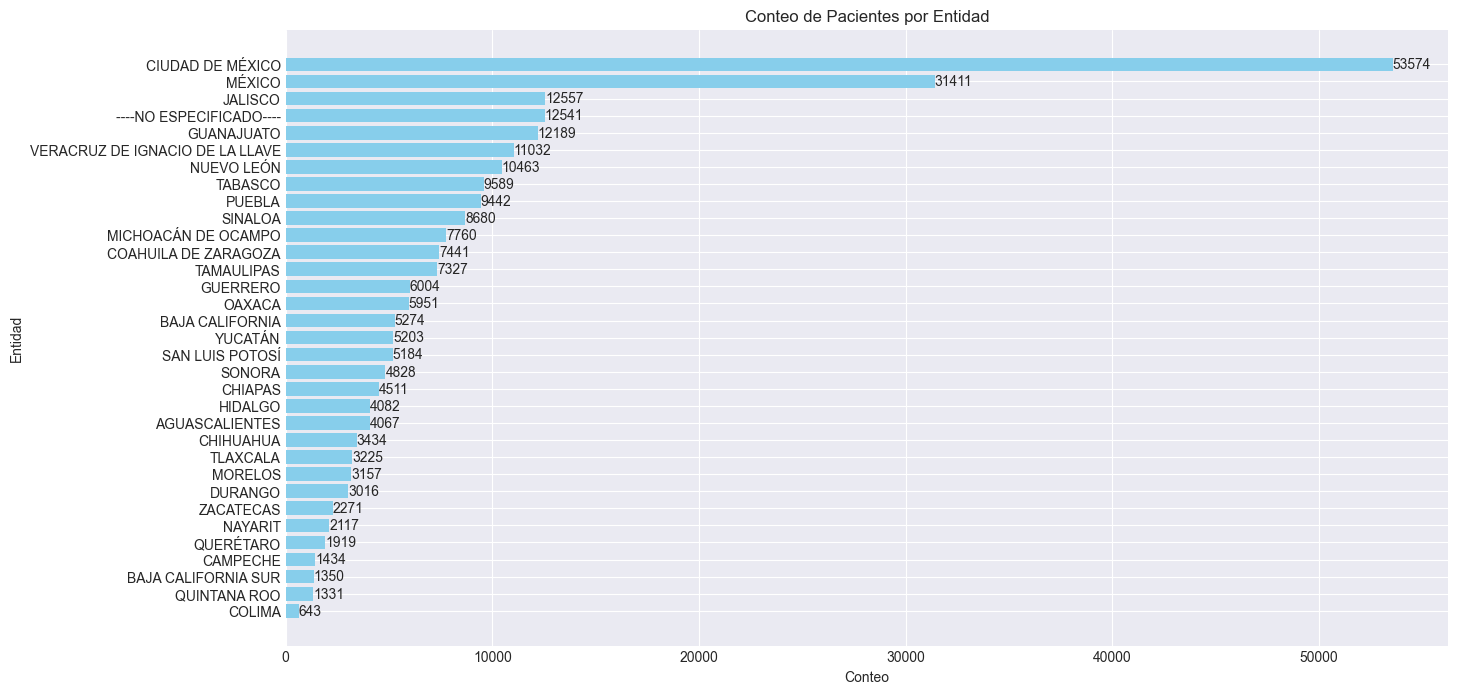

In [223]:
data = df_entidad.copy()
data.sort_values(by='cant_pacientes', inplace=True)
keys = data['ENTIDAD']
values = data['cant_pacientes']

# Creating the horizontal bar plot
plt.figure(figsize=(15, 8))
bars = plt.barh(keys, values, color='skyblue')

# Adding labels next to each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width()}', va='center')

# Adding title and labels
plt.title('Conteo de Pacientes por Entidad')
plt.xlabel('Conteo')
plt.ylabel('Entidad')

# Display the plot
plt.show()

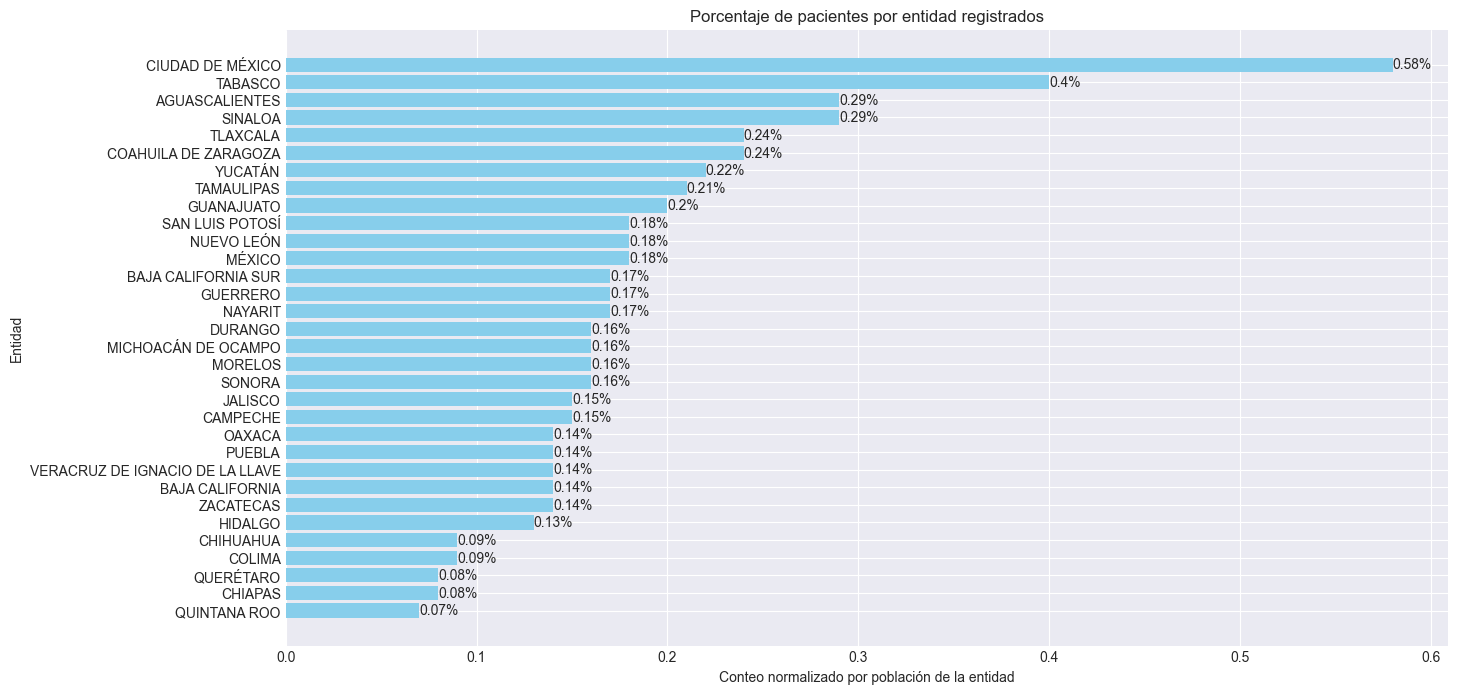

In [224]:
data = df_entidad.copy()
data.drop([32], inplace=True)
data.sort_values(by='cant_pacientes_normalizada', inplace=True)
keys = data['ENTIDAD']
values = data['cant_pacientes_normalizada']

# Creating the horizontal bar plot
plt.figure(figsize=(15, 8))
bars = plt.barh(keys, values, color='skyblue')

# Adding labels next to each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width()}%', va='center')

# Adding title and labels
plt.title('Porcentaje de pacientes por entidad registrados')
plt.xlabel('Conteo normalizado por población de la entidad')
plt.ylabel('Entidad')

# Display the plot
plt.show()

### ORIGEN - USMER o fuera de USMER (Unidades Monitoras de Enfermedades RespiratoriaS)

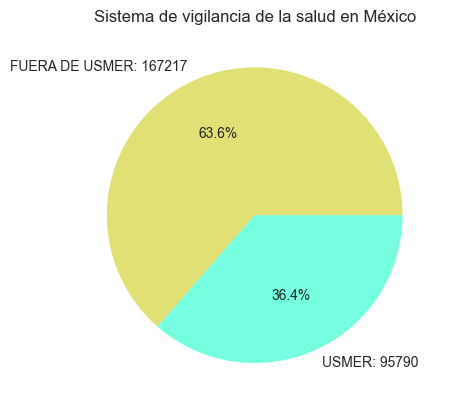

In [225]:
grafica_pastel('ORIGEN',
               titulo='Sistema de vigilancia de la salud en México',
               diccionario = {1: "USMER", 2: "FUERA DE USMER",},
               explode=(0.0, 0),
               colors=[(0.8, .8, .1, 0.6), (0.1, 1, .8, 0.6)])

### SECTOR - Institución de Salud que proporcionó el cuidado al paciente

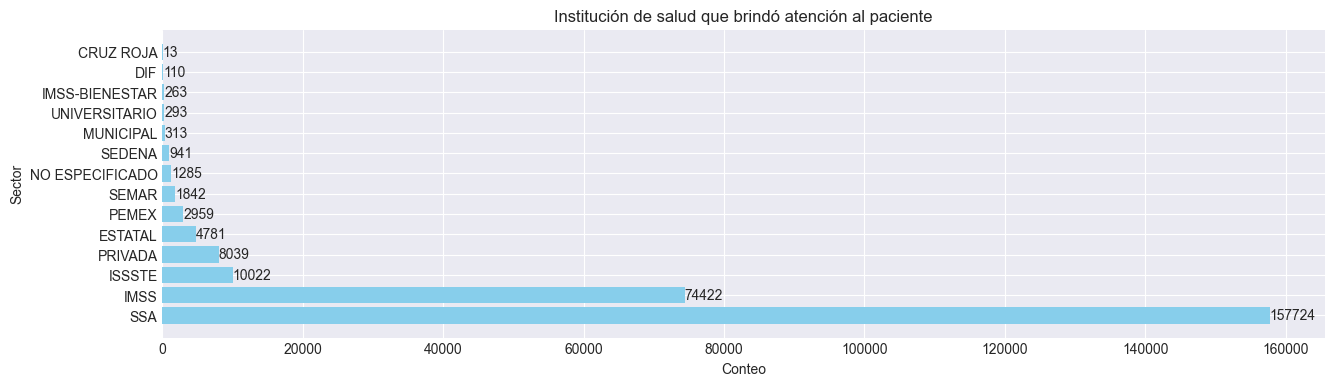

In [226]:
SECTOR = {
    1: "CRUZ ROJA",
    2: "DIF",
    3: "ESTATAL",
    4: "IMSS",
    5: "IMSS-BIENESTAR",
    6: "ISSSTE",
    7: "MUNICIPAL",
    8: "PEMEX",
    9: "PRIVADA",
    10: "SEDENA",
    11: "SEMAR",
    12: "SSA",
    13: "UNIVERSITARIO",
    99: "NO ESPECIFICADO"
}
sector_value_counts = pd.Series([SECTOR[item] for item in df_clean['SECTOR']]).value_counts()


# Using value_counts
value_counts = sector_value_counts

# Extracting keys (unique values) and values (counts)
keys = value_counts.index.tolist()
values = value_counts.values.tolist()

# Creating the horizontal bar plot
plt.figure(figsize=(15, 4))
bars = plt.barh(keys, values, color='skyblue')

# Adding labels next to each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width()}', va='center')

# Adding title and labels
plt.title('Institución de salud que brindó atención al paciente')
plt.xlabel('Conteo')
plt.ylabel('Sector')

# Display the plot
plt.show()

### SEXO - Sexo del paciente

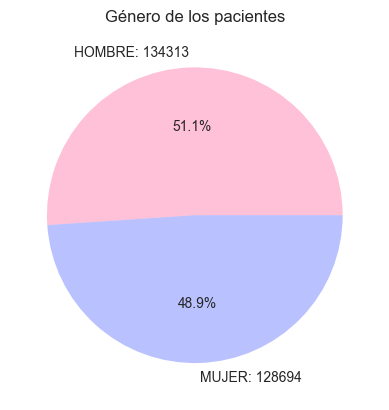

In [227]:
grafica_pastel('SEXO',
               titulo='Género de los pacientes',
               diccionario = {1: "MUJER", 2: "HOMBRE", 3: "NO ESPECIFICADO"},
               explode=(0.0, 0),
               colors=[(1, 0.2, 0.5, 0.3),(0.1, 0.2, 1, 0.3)])

### TIPO_PACIENTE - Indica si el paciente tuvo que ser hospitalizado o si fue ambulatorio

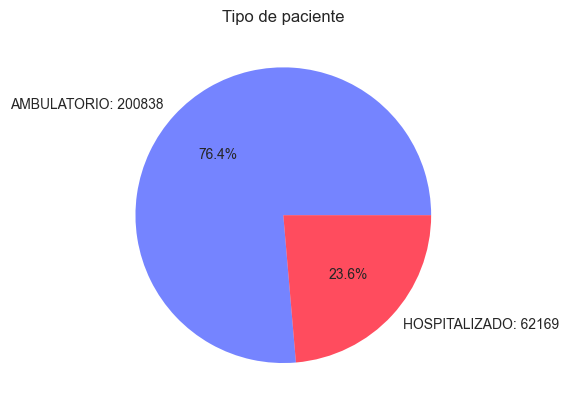

In [228]:
grafica_pastel('TIPO_PACIENTE',
               titulo='Tipo de paciente',
               diccionario = {1: "AMBULATORIO", 2: "HOSPITALIZADO",},
               explode=(0.0, 0),
               colors=[(0.1, 0.2, 1, 0.6), (1, 0.0, 0.1, 0.7)])

### INTUBADO

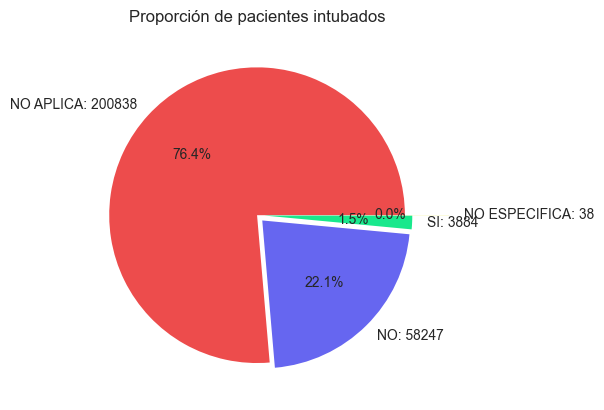

In [229]:
grafica_pastel('INTUBADO',
               titulo='Proporción de pacientes intubados',
               diccionario = None,
               explode=(0.0,0.05,0.05,0.3),
               colors=[(0.9, 0.0, .0, 0.7), (0, 0.0, 0.9, 0.6), (0.0, 0.9, .5, 0.9), (0.9, 0.9, .0, 1)])

### NEUMONIA

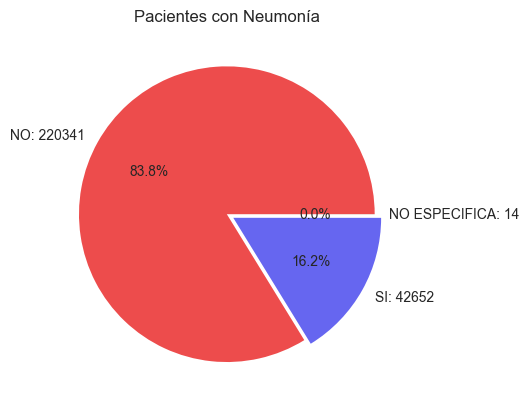

In [230]:
grafica_pastel('NEUMONIA',
               titulo='Pacientes con Neumonía',
               diccionario = None,
               explode=(0.0,0.05,0.0),
               colors=[(0.9, 0.0, .0, 0.7), (0, 0.0, 0.9, 0.6), (0.0, 0.9, .5, 0.9), (0.9, 0.9, .0, 1)])

### NACIONALIDAD

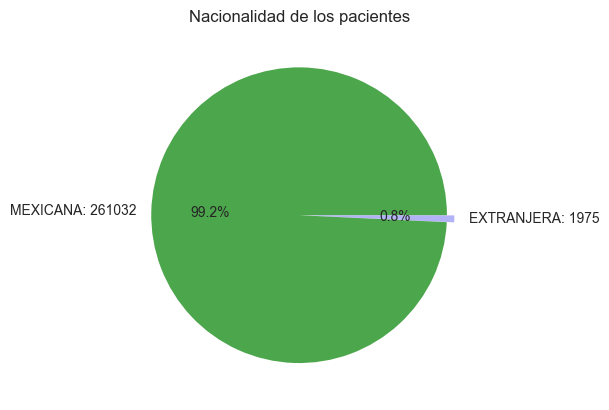

In [231]:
grafica_pastel('NACIONALIDAD',
               titulo='Nacionalidad de los pacientes',
               diccionario = {1: "MEXICANA", 2: "EXTRANJERA",},
               explode=(0.0,0.05),
               colors=[(0.0, 0.5, .0, 0.7), (0, 0.0, 0.9, 0.3)])

### EMBARAZO

In [232]:
data = df_clean[(df_clean['EMBARAZO'] == 1) | (df_clean['EMBARAZO'] == 2)].copy()
data['EMBARAZO'].value_counts()

2    126077
1      2064
Name: EMBARAZO, dtype: int64

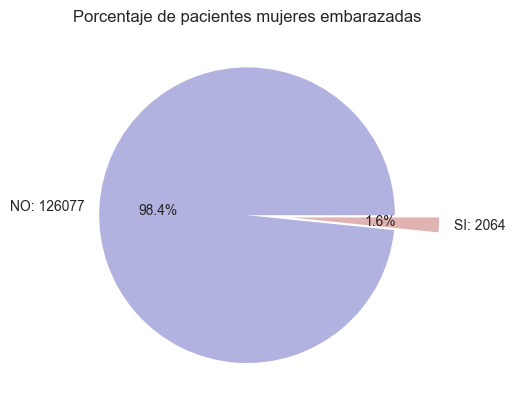

In [233]:
data = df_clean[(df_clean['EMBARAZO'] == 1) | (df_clean['EMBARAZO'] == 2)].copy()
dictionary = {1: "SI",
                      2: "NO",
                      97: "NO APLICA",
                      98: "SE IGNORA",
                      99: "NO ESPECIFICA"}
value_counts = pd.Series([dictionary[item] for item in data['EMBARAZO']]).value_counts()

plt.pie(value_counts,
        labels = ['NO: ' + str(value_counts[0]),
                  'SI: ' + str(value_counts[1]),],
        explode=(0.0,0.3),
        colors = [(0.0, 0.0, .6, 0.3), (.6, 0.0, 0.0, 0.3)],
        autopct='%1.1f%%')
plt.title('Porcentaje de pacientes mujeres embarazadas');

### Lengua indígena

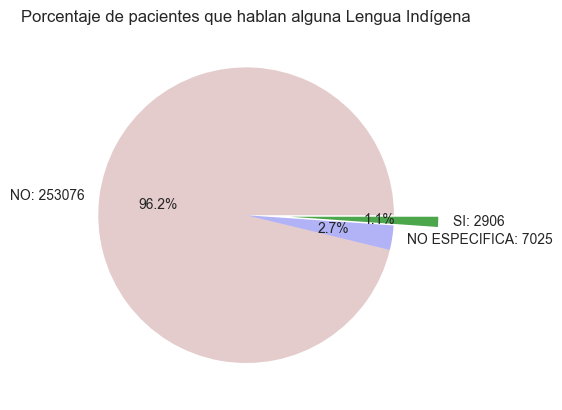

In [234]:
grafica_pastel('HABLA_LENGUA_INDIG',
               titulo='Porcentaje de pacientes que hablan alguna Lengua Indígena',
               diccionario = None,
               explode=(0.0,0, .3),
               colors=[(0.5, 0.0, .0, 0.2), (0, 0.0, 0.9, 0.3), (0.0, 0.5, .0, 0.7)])

### DIABETES

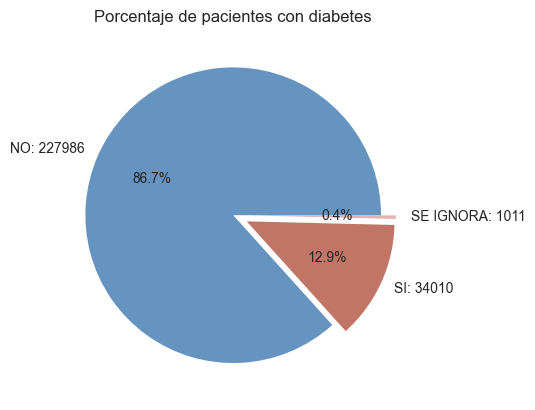

In [235]:
grafica_pastel('DIABETES',
               titulo='Porcentaje de pacientes con diabetes',
               diccionario = None,
               explode=(0.0,.1, 0.1),
               colors=[(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

### EPOC

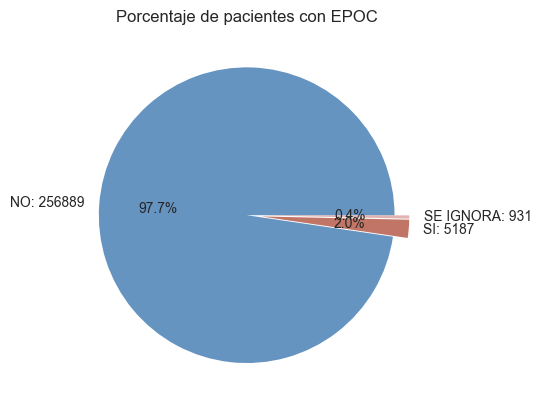

In [236]:
grafica_pastel('EPOC',
               titulo = 'Porcentaje de pacientes con EPOC',
               diccionario = None,
               explode=(0.0,.1, 0.1),
               colors = [(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

### ASMA

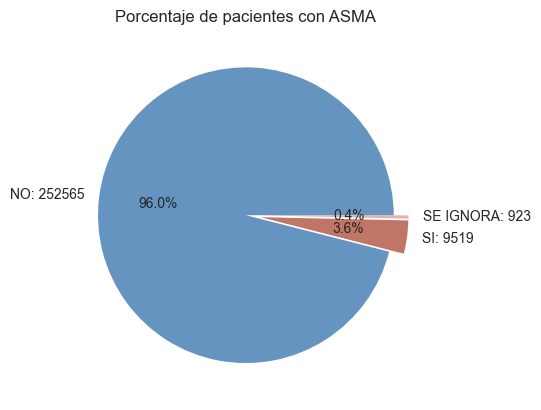

In [237]:
grafica_pastel('ASMA',
               titulo = 'Porcentaje de pacientes con ASMA',
               diccionario = None,
               explode=(0.0,.1, 0.1),
               colors = [(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

### INMUNOSUPR

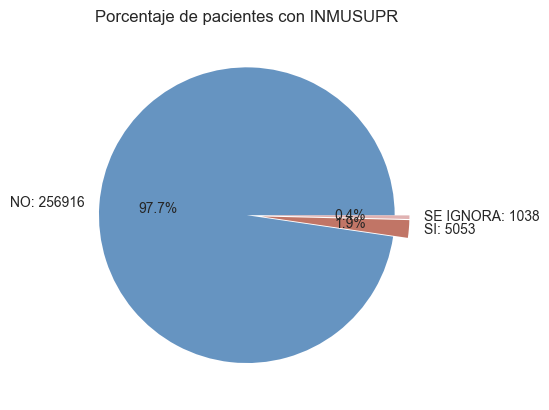

In [238]:
grafica_pastel('INMUSUPR',
               titulo = 'Porcentaje de pacientes con INMUSUPR',
               diccionario = None,
               explode=(0.0,.1, 0.1),
               colors = [(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

### HIPERTENSION

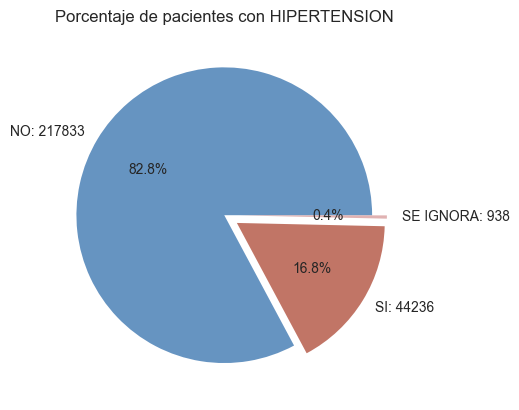

In [239]:
grafica_pastel('HIPERTENSION',
               titulo = 'Porcentaje de pacientes con HIPERTENSION',
               diccionario = None,
               explode=(0.0,.1, 0.1),
               colors = [(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

### CARDIOVASCULAR

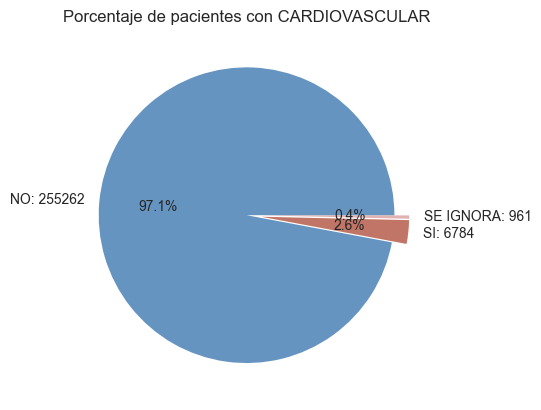

In [240]:
grafica_pastel('CARDIOVASCULAR',
               titulo='Porcentaje de pacientes con CARDIOVASCULAR',
               diccionario=None,
               explode=(0.0, .1, 0.1),
               colors=[(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

### OBESIDAD

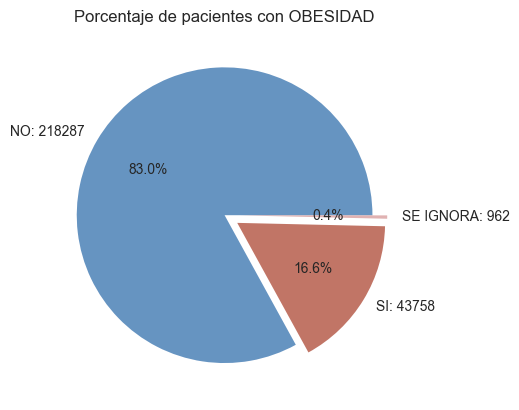

In [241]:
grafica_pastel('OBESIDAD',
               titulo='Porcentaje de pacientes con OBESIDAD',
               diccionario=None,
               explode=(0.0, .1, 0.1),
               colors=[(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

### RENAL_CRONICA

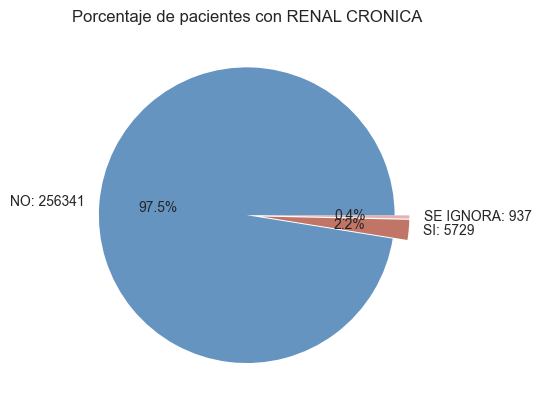

In [242]:
grafica_pastel('RENAL_CRONICA',
               titulo='Porcentaje de pacientes con RENAL CRONICA',
               diccionario=None,
               explode=(0.0, .1, 0.1),
               colors=[(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

### TABAQUISMO

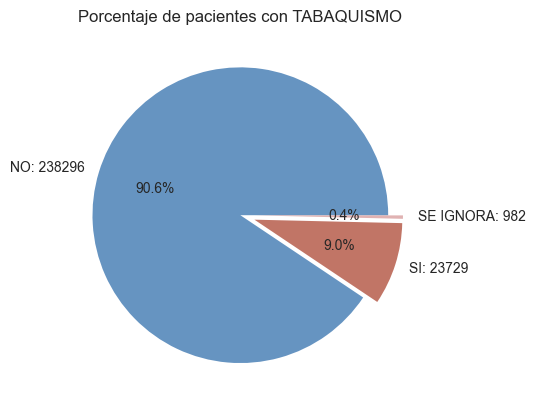

In [243]:
grafica_pastel('TABAQUISMO',
               titulo='Porcentaje de pacientes con TABAQUISMO',
               diccionario=None,
               explode=(0.0, .1, 0.1),
               colors=[(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

### UCI

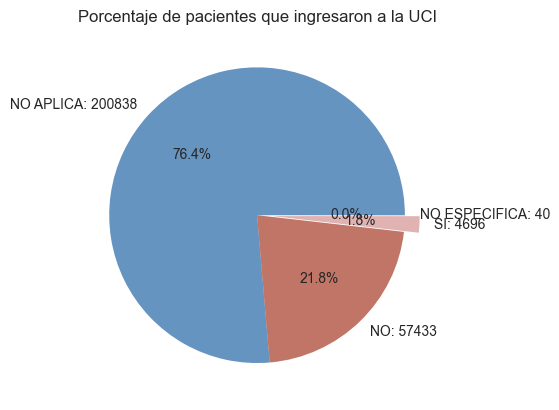

In [244]:
grafica_pastel('UCI',
               titulo='Porcentaje de pacientes que ingresaron a la UCI',
               diccionario=None,
               explode=(0.0, 0, 0.1, .0),
               colors=[(0.0, 0.3, .6, 0.6), (.6, 0.1, 0.0, 0.6), (.6, 0.0, 0.0, 0.3)])

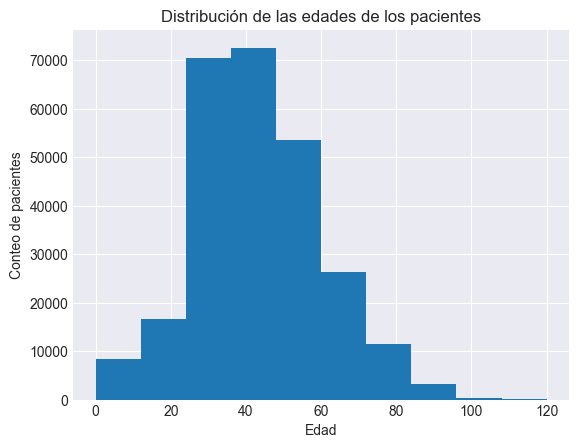

In [245]:
df_clean['EDAD'].plot(kind='hist', title="Distribución de las edades de los pacientes")
plt.xlabel('Edad')
plt.ylabel('Conteo de pacientes')
plt.show();

<AxesSubplot:>

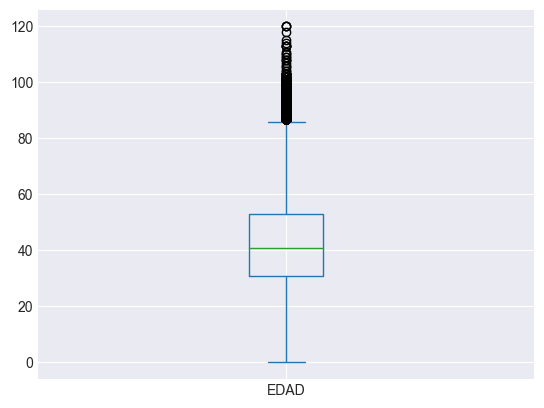

In [246]:
df_clean['EDAD'].plot(kind='box')

### RESULTADO - Resultado de las pruebas COVID

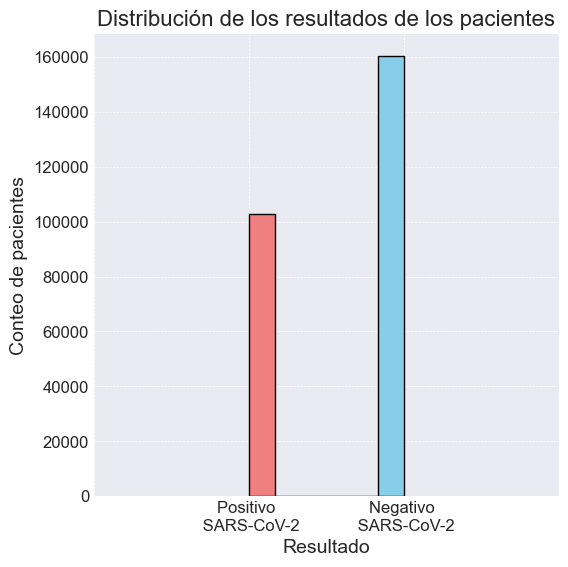

In [247]:
# Set the style for the plot
plt.style.use('seaborn-darkgrid')

# Create the plot with a specified figure size
plt.figure(figsize=(6, 6))

# Plot the histogram
ax = df_clean['RESULTADO'].plot(kind='hist', bins=6, color='skyblue', edgecolor='black')

# Set the title and labels with larger fonts
plt.title("Distribución de los resultados de los pacientes", fontsize=16)
plt.xlabel('Resultado', fontsize=14)
plt.ylabel('Conteo de pacientes', fontsize=14)

# Customize the x-ticks
plt.xticks([0, 1, 2,3], ['', 'Positivo \n SARS-CoV-2', 'Negativo \n SARS-CoV-2', ''], fontsize=12)

# Customize the y-ticks
plt.yticks(fontsize=12)

# Add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Change colors of each bar
bars = ax.patches
bars[0].set_facecolor('lightcoral')
bars[1].set_facecolor('lightgreen')
bars[2].set_facecolor('lightgreen')
bars[3].set_facecolor('lightgreen')
#lightcoral

# Show the plot
plt.show()

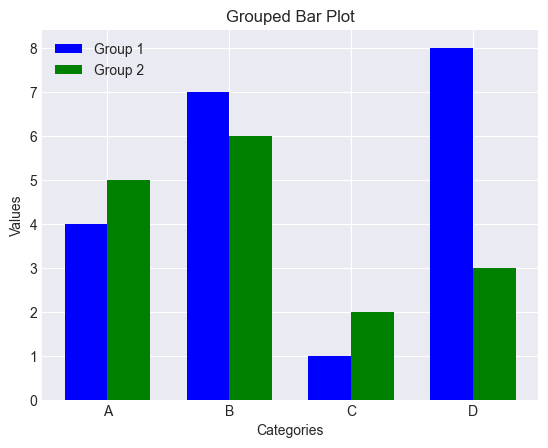

In [248]:

# Sample data
categories = ['A', 'B', 'C', 'D']
values1 = [4, 7, 1, 8]
values2 = [5, 6, 2, 3]

# Define the position of bars
bar_width = 0.35
index = np.arange(len(categories))

# Creating the bar plot
fig, ax = plt.subplots()
bar1 = ax.bar(index, values1, bar_width, label='Group 1', color='blue')
bar2 = ax.bar(index + bar_width, values2, bar_width, label='Group 2', color='green')

# Adding title and labels
plt.title('Grouped Bar Plot')
plt.xlabel('Categories')
plt.ylabel('Values')
plt.xticks(index + bar_width / 2, categories)

# Adding legend
plt.legend()

# Display the plot
plt.show()

## Análisis de correlación
Puede proporcionar información sobre posibles predicores importantes para un análisis posterior.

## Análisis de distribución de variables
Examina la distribución de las variables en los datos para detectar sesgos o asimetrías.

## Segmentación
Dividir los datos en segmentos o grupos con características similares para analizar patrones específicos en elgrrupo. 

### Por rangos de edad

In [249]:
df_seg_edad = df_clean[['EDAD', 'RESULTADO', 'FECHA_DEF']].copy()

In [250]:
def discretizar_edad(edad):
    if edad < 12:
        return 'niño'
    elif (edad >= 12) & (edad < 18):
        return  'joven'
    elif (edad >= 18) & (edad < 30):
        return 'adulto joven'
    elif (edad >= 30) & (edad < 60):
        return 'adulto'
    elif edad >= 60:
        return 'adulto mayor'

In [251]:
df_seg_edad['EDAD_DISCRETA'] = [discretizar_edad(edad) for edad in df_seg_edad['EDAD']]

In [252]:
df_seg_edad.head(15)

,EDAD,RESULTADO,FECHA_DEF,EDAD_DISCRETA
0,74,2,2200-01-01,adulto mayor
1,71,2,2200-01-01,adulto mayor
2,50,1,2200-01-01,adulto
3,25,1,2200-01-01,adulto joven
4,28,2,2200-01-01,adulto joven
5,67,2,2200-01-01,adulto mayor
6,44,2,2200-01-01,adulto
7,62,2,2200-01-01,adulto mayor
8,30,2,2200-01-01,adulto
9,30,2,2200-01-01,adulto


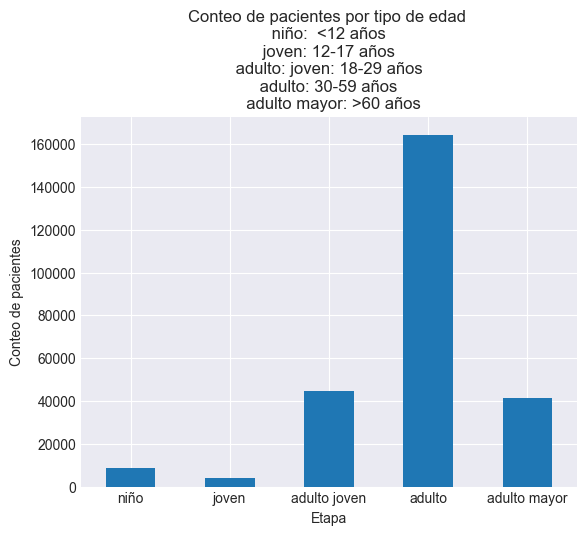

In [253]:
df_seg_edad['EDAD_DISCRETA'].value_counts().reindex(['niño','joven','adulto joven','adulto','adulto mayor']).plot(kind='bar')
plt.title('Conteo de pacientes por tipo de edad \n niño:  <12 años \n joven: 12-17 años \n adulto: joven: 18-29 años \n adulto: 30-59 años \n  adulto mayor: >60 años')
plt.ylabel('Conteo de pacientes')
plt.xlabel('Etapa')
plt.xticks(rotation=0)
plt.show()

### Por rangos de edad y resultado

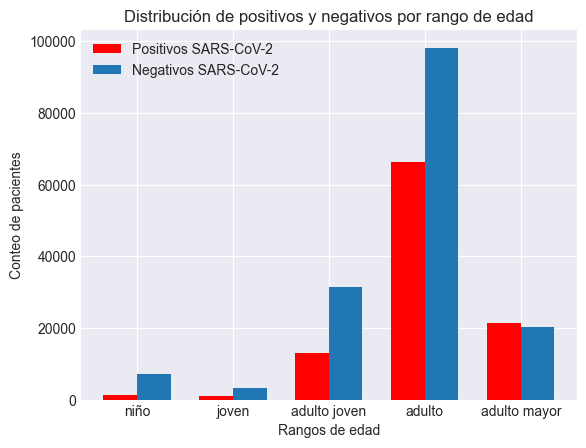

In [254]:
rangos = ['niño','joven','adulto joven','adulto','adulto mayor']
positivos = []
negativos = []

for rango in rangos:
    resultados_por_rango = dict(df_seg_edad.loc[df_seg_edad['EDAD_DISCRETA'] == rango, 'RESULTADO'].value_counts())
    positivos.append(resultados_por_rango[1])
    negativos.append(resultados_por_rango[2])
    
    

# Sample data
categories = rangos
values1 = positivos
values2 = negativos

# Define the position of bars
bar_width = 0.35
index = np.arange(len(categories))

# Creating the bar plot
fig, ax = plt.subplots()
bar1 = ax.bar(index, values1, bar_width, label='Positivos SARS-CoV-2', color='r')
bar2 = ax.bar(index + bar_width, values2, bar_width, label='Negativos SARS-CoV-2')

# Adding title and labels
plt.title('Distribución de positivos y negativos por rango de edad')
plt.xlabel('Rangos de edad')
plt.ylabel('Conteo de pacientes')
plt.xticks(index + bar_width / 2, categories)

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [255]:
df_seg_edad['FECHA_DEF']

0        2200-01-01
1        2200-01-01
2        2200-01-01
3        2200-01-01
4        2200-01-01
            ...    
263002   2200-01-01
263003   2020-05-07
263004   2020-05-18
263005   2200-01-01
263006   2200-01-01
Name: FECHA_DEF, Length: 263007, dtype: datetime64[ns]

In [256]:
df_seg_edad['DEFUNCION'] = [0 if fecha==pd.to_datetime('2200-01-01') else 1 for fecha in df_seg_edad['FECHA_DEF']]
df_seg_edad.head()

,EDAD,RESULTADO,FECHA_DEF,EDAD_DISCRETA,DEFUNCION
0,74,2,2200-01-01,adulto mayor,0
1,71,2,2200-01-01,adulto mayor,0
2,50,1,2200-01-01,adulto,0
3,25,1,2200-01-01,adulto joven,0
4,28,2,2200-01-01,adulto joven,0


In [257]:
df_seg_edad['DEFUNCION'].value_counts()

0    258465
1      4542
Name: DEFUNCION, dtype: int64

In [258]:
df_riesgos = df_clean[['FECHA_DEF', 'RESULTADO',
                       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'CARDIOVASCULAR', 'OBESIDAD','RENAL_CRONICA', 'TABAQUISMO', 'UCI']
                    ].copy()# Filtrar por los que dieron positivo
df_riesgos = df_riesgos[df_riesgos['RESULTADO']==1]
#Agregar column de defuncion
df_riesgos['DEFUNCION'] = [0 if fecha==pd.to_datetime('2200-01-01') else 1 for fecha in df_riesgos['FECHA_DEF']]
#eliminar colum de fecha def
df_riesgos.drop(columns = 'FECHA_DEF', inplace=True)
#Filtrar por los que fallecieron
df_riesgos = df_riesgos[df_riesgos['DEFUNCION']==1]
df_riesgos

,RESULTADO,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,UCI,DEFUNCION
96,1,1,2,2,1,1,1,1,1,2,2,1
190,1,2,2,2,2,2,2,2,2,1,2,1
306,1,2,2,2,2,2,2,2,2,2,2,1
323,1,2,2,2,2,2,2,2,2,2,2,1
326,1,2,2,2,2,1,2,1,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
262982,1,1,1,2,2,1,2,1,2,2,2,1
262984,1,1,2,2,2,1,1,2,2,2,2,1
262996,1,2,2,2,2,2,2,2,2,2,97,1
263003,1,1,1,2,2,2,2,1,2,2,2,1


In [259]:
riesgos = ['DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'CARDIOVASCULAR', 'OBESIDAD','RENAL_CRONICA', 'TABAQUISMO', 'UCI']
conteos = []

for riesgo in tqdm(riesgos):
    conteos.append(dict(df_riesgos[riesgo].value_counts())[1])

100%|██████████| 10/10 [00:00<00:00, 4996.79it/s]


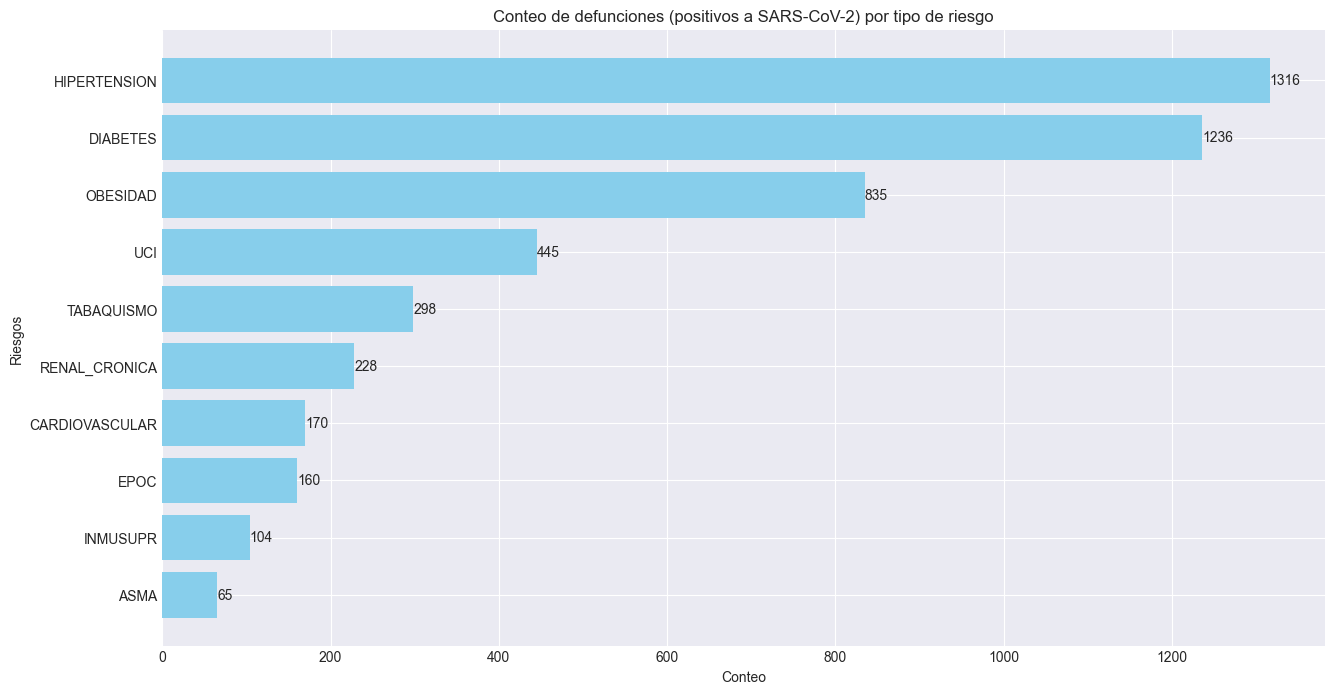

In [260]:
data = pd.DataFrame({'riesgos' : riesgos, 'conteos':conteos})
data.sort_values(by='conteos', inplace=True)
keys = data['riesgos']
values = data['conteos']

# Creating the horizontal bar plot
plt.figure(figsize=(15, 8))
bars = plt.barh(keys, values, color='skyblue')

# Adding labels next to each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width()}', va='center')

# Adding title and labels
plt.title('Conteo de defunciones (positivos a SARS-CoV-2) por tipo de riesgo')
plt.xlabel('Conteo')
plt.ylabel('Riesgos')

# Display the plot
plt.show()

## Exploración de series temporales
Si los datos tienen una dimensión temporal, realizar un análisis de series temporales para identificar tendencias, estacionalidades, y ciclos en los datos a lo largo del tiempo.

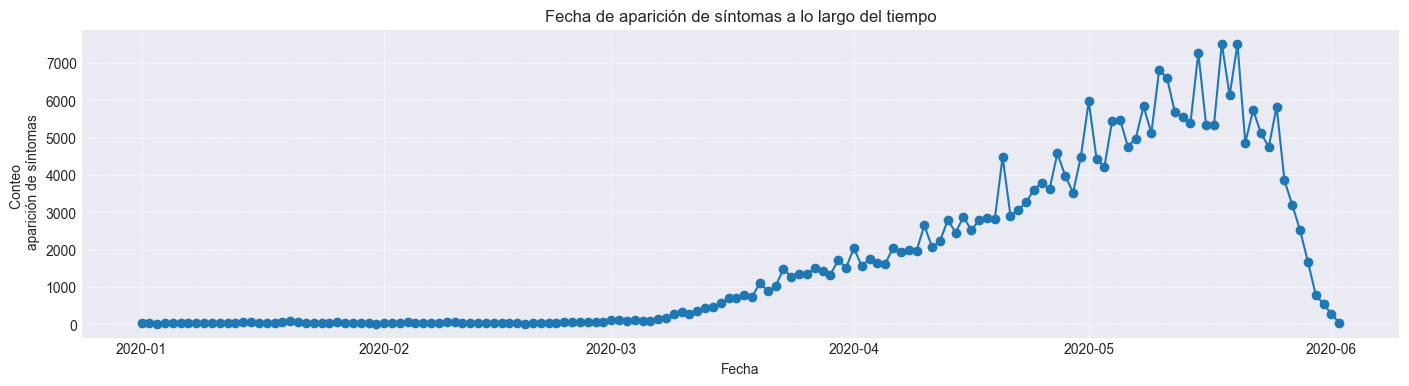

In [261]:
fecha_sintomas = dict(df_clean['FECHA_SINTOMAS'].value_counts())
fecha_sintomas = dict(sorted(fecha_sintomas.items()))

plt.figure(figsize=(17,4))
fechas = list(fecha_sintomas.keys())
conteo = list(fecha_sintomas.values())
plt.scatter(fechas, conteo)
plt.plot(fechas, conteo)
plt.title('Fecha de aparición de síntomas a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Conteo \n aparición de síntomas')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

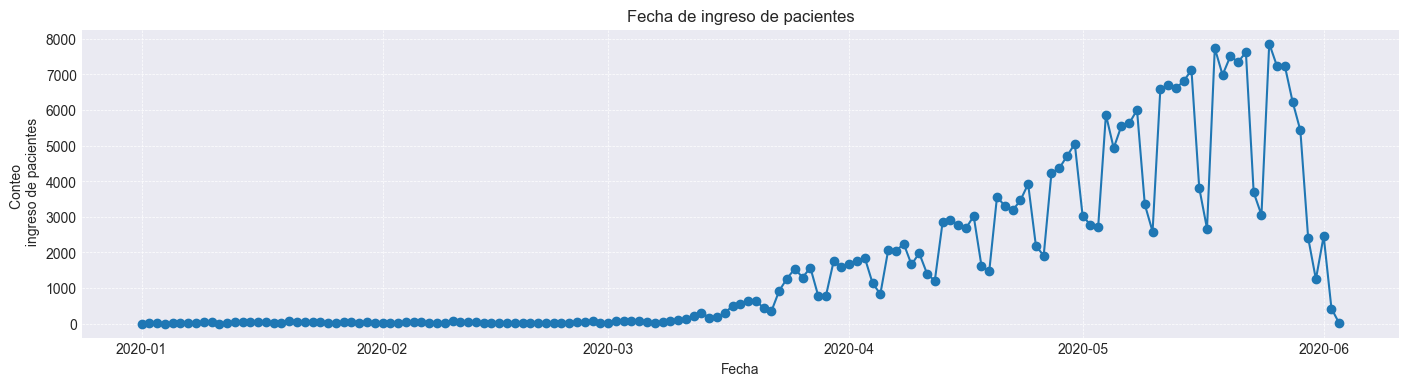

In [262]:
fecha_ingreso = dict(df_clean['FECHA_INGRESO'].value_counts())
fecha_ingreso = dict(sorted(fecha_ingreso.items()))

plt.figure(figsize=(17,4))
fechas = list(fecha_ingreso.keys())
conteo = list(fecha_ingreso.values())
plt.scatter(fechas, conteo)
plt.plot(fechas, conteo)
plt.title('Fecha de ingreso de pacientes')
plt.xlabel('Fecha')
plt.ylabel('Conteo \n ingreso de pacientes')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

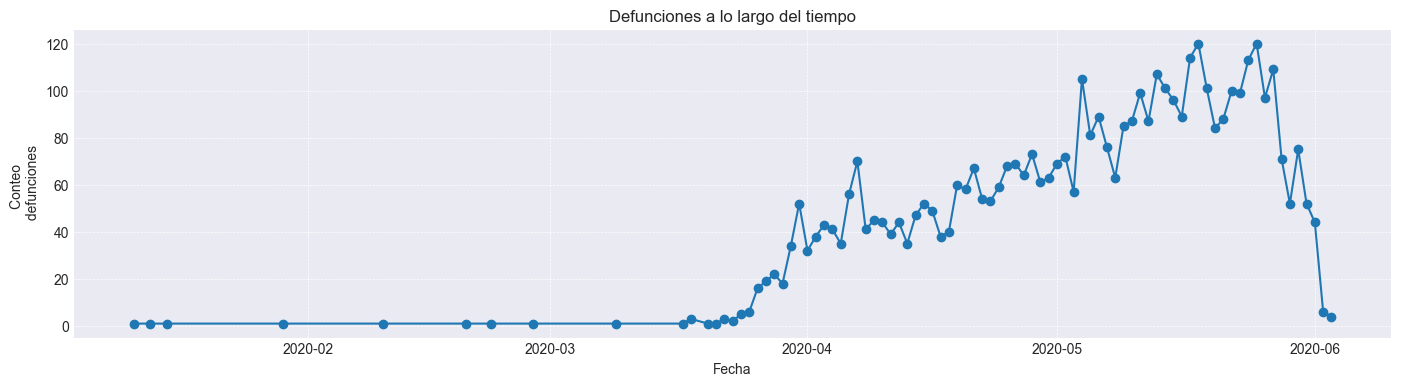

In [263]:
fecha_def = df_clean['FECHA_DEF'][df_clean['FECHA_DEF'] != pd.to_datetime('2200-01-01')]
fecha_def = dict(fecha_def.value_counts())
fecha_def = dict(sorted(fecha_def.items()))

plt.figure(figsize=(17,4))
fechas_defunciones = list(fecha_def.keys())
conteo_defunciones = list(fecha_def.values())
plt.scatter(fechas_defunciones, conteo_defunciones)
plt.plot(fechas_defunciones, conteo_defunciones)
plt.title('Defunciones a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Conteo \n defunciones')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

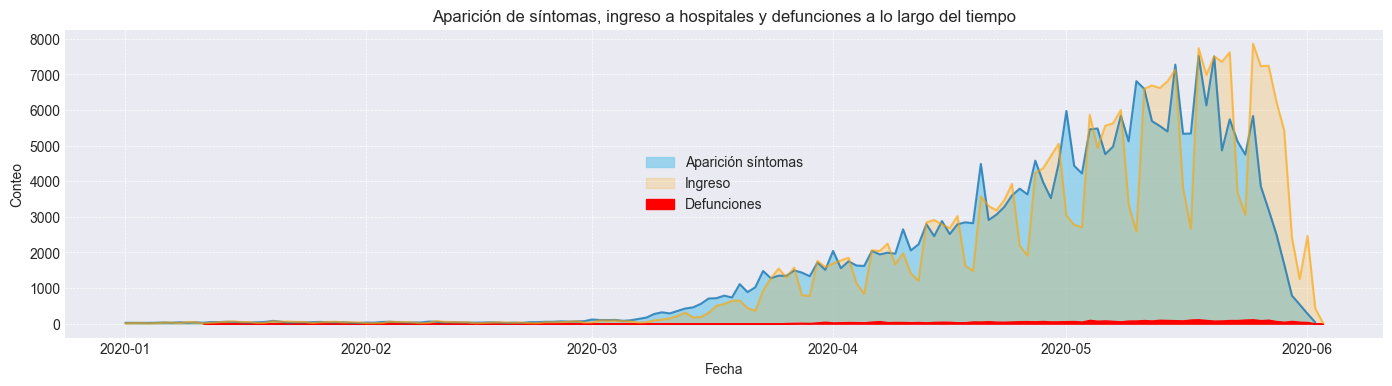

In [264]:
plt.figure(figsize=(17,4))

#Sintomas
fecha_sintomas = dict(df_clean['FECHA_SINTOMAS'].value_counts())
fecha_sintomas = dict(sorted(fecha_sintomas.items()))
fechas = list(fecha_sintomas.keys())
conteo = list(fecha_sintomas.values())
#plt.scatter(fechas, conteo)
plt.plot(fechas, conteo, alpha=0.8)
plt.fill_between(fechas, conteo, color="skyblue", alpha=0.8, label='Aparición síntomas')

#Ingreso
fecha_ingreso = dict(df_clean['FECHA_INGRESO'].value_counts())
fecha_ingreso = dict(sorted(fecha_ingreso.items()))
fechas = list(fecha_ingreso.keys())
conteo = list(fecha_ingreso.values())
#plt.scatter(fechas, conteo)
plt.plot(fechas, conteo, c='orange', alpha=.6)
plt.fill_between(fechas, conteo, color="orange", alpha=0.2, label='Ingreso')

#Defunciones
fecha_def = df_clean['FECHA_DEF'][df_clean['FECHA_DEF'] != pd.to_datetime('2200-01-01')]
fecha_def = dict(fecha_def.value_counts())
fecha_def = dict(sorted(fecha_def.items()))
fechas_defunciones = list(fecha_def.keys())
conteo_defunciones = list(fecha_def.values())
#plt.scatter(fechas_defunciones, conteo_defunciones)
#plt.plot(fechas_defunciones, conteo_defunciones)
plt.fill_between(fechas_defunciones, conteo_defunciones, color="red", alpha=1, label='Defunciones')


plt.title('Aparición de síntomas, ingreso a hospitales y defunciones a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Conteo')
plt.legend(loc = 'center')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Modelado de datos

## Preprocesar datos

In [265]:
data = df_clean.copy()
data = data[['ORIGEN', 'SEXO', 'TIPO_PACIENTE','INTUBADO', 'NEUMONIA', 'EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'UCI', 'RESULTADO', 'FECHA_DEF']]
data

,ORIGEN,SEXO,TIPO_PACIENTE,INTUBADO,NEUMONIA,EDAD,EMBARAZO,DIABETES,EPOC,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,UCI,RESULTADO,FECHA_DEF
0,2,2,1,97,2,74,97,1,2,2,2,1,2,2,2,97,2,2200-01-01
1,1,1,2,2,2,71,2,1,1,2,2,1,2,1,99,2,2,2200-01-01
2,1,2,2,2,1,50,97,2,2,2,2,2,2,2,99,2,1,2200-01-01
3,2,1,1,97,2,25,2,2,2,2,2,1,2,2,99,97,1,2200-01-01
4,1,1,1,97,2,28,2,2,2,2,2,2,2,2,99,97,2,2200-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263002,2,2,1,97,2,39,97,2,2,2,2,2,2,2,1,97,1,2200-01-01
263003,2,1,2,2,1,53,2,1,1,2,2,1,2,2,99,2,1,2020-05-07
263004,1,1,2,2,2,65,2,1,2,2,2,2,1,2,99,2,1,2020-05-18
263005,2,2,2,2,1,71,97,2,2,2,2,2,2,2,2,2,1,2200-01-01


In [266]:
def discretizar_edad(edad):
    if edad < 12:
        return 0
    elif (edad >= 12) & (edad < 18):
        return 1
    elif (edad >= 18) & (edad < 30):
        return 2
    elif (edad >= 30) & (edad < 60):
        return 3
    elif edad >= 60:
        return 4


data['EDAD_DISCRETA'] = [discretizar_edad(edad) for edad in data['EDAD']]
data.drop(columns='EDAD', inplace=True)
data

,ORIGEN,SEXO,TIPO_PACIENTE,INTUBADO,NEUMONIA,EMBARAZO,DIABETES,EPOC,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,UCI,RESULTADO,FECHA_DEF,EDAD_DISCRETA
0,2,2,1,97,2,97,1,2,2,2,1,2,2,2,97,2,2200-01-01,4
1,1,1,2,2,2,2,1,1,2,2,1,2,1,99,2,2,2200-01-01,4
2,1,2,2,2,1,97,2,2,2,2,2,2,2,99,2,1,2200-01-01,3
3,2,1,1,97,2,2,2,2,2,2,1,2,2,99,97,1,2200-01-01,2
4,1,1,1,97,2,2,2,2,2,2,2,2,2,99,97,2,2200-01-01,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263002,2,2,1,97,2,97,2,2,2,2,2,2,2,1,97,1,2200-01-01,3
263003,2,1,2,2,1,2,1,1,2,2,1,2,2,99,2,1,2020-05-07,3
263004,1,1,2,2,2,2,1,2,2,2,2,1,2,99,2,1,2020-05-18,4
263005,2,2,2,2,1,97,2,2,2,2,2,2,2,2,2,1,2200-01-01,4


In [267]:
data['DEFUNCION'] = [0 if fecha != pd.to_datetime('2200-01-01') else 1 for fecha in data['FECHA_DEF']]
data.drop(columns='FECHA_DEF', inplace=True)

In [268]:
attributos = ['ORIGEN', 'SEXO', 'TIPO_PACIENTE','INTUBADO', 'NEUMONIA', 'EMBARAZO', 'DIABETES', 'EPOC', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'UCI']

for atributo in attributos:
    data[atributo] = data[atributo].replace(97,3)
    data[atributo] = data[atributo].replace(98,3)
    data[atributo] = data[atributo].replace(99,3)

In [269]:
data.describe()

,ORIGEN,SEXO,TIPO_PACIENTE,INTUBADO,NEUMONIA,EMBARAZO,DIABETES,EPOC,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,UCI,RESULTADO,EDAD_DISCRETA,DEFUNCION
count,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.00000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000,263007.000000
mean,1.635789,1.510682,1.236378,2.748999,1.837883,2.504937,1.874532,1.983818,1.968499,1.97786,1.837282,1.981780,1.913512,1.946382,2.745919,1.609672,2.860289,0.982730
std,0.481209,0.499887,0.424858,0.466407,0.368704,0.515434,0.342658,0.151657,0.201815,0.17017,0.378889,0.158156,0.294068,0.826302,0.474589,0.487825,0.812285,0.130274
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,3.000000,1.000000
50%,2.000000,2.000000,1.000000,3.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,3.000000,1.000000
75%,2.000000,2.000000,1.000000,3.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,3.000000,3.000000,2.000000,3.000000,1.000000
max,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.00000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,4.000000,1.000000


In [270]:
Y = np.array(data['DEFUNCION'])
X = np.array(data.drop(columns='DEFUNCION', inplace=False))

In [271]:
X.shape, Y.shape

((263007, 17), (263007,))

In [272]:
data['DEFUNCION'].value_counts()

1    258465
0      4542
Name: DEFUNCION, dtype: int64

## Split into train and est split

In [344]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(210405, 17) (210405,)
(52602, 17) (52602,)


## Balance classes

In [355]:
# Perform undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Perform oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_resampled, y_resampled)

ValueError: The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.

In [377]:
ros = SMOTE(sampling_strategy=0.035)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

In [378]:
from collections import Counter

print("Original dataset shape:", Counter(y_train))
print("Resampled dataset shape:", Counter(y_resampled))

Original dataset shape: Counter({1: 206796, 0: 3609})
Resampled dataset shape: Counter({0: 7237, 1: 7237})


In [379]:
model = Sequential([
    Dense(2, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer with 10 neurons
    Dense(2, activation='relu'),  # Second hidden layer with 10 neurons
    Dense(2, activation='softmax')  # Output layer with 2 neurons (for 2 classes)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              )

In [380]:
history = model.fit(X_resampled, y_resampled, epochs=10, validation_split=0.2, batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                patience=5,
                                                                restore_best_weights=True
                                                                )
                               ]
                    )

Epoch 1/10
362/362 [==============================] - 1s 3ms/step - loss: 0.4592 - accuracy: 0.8312 - val_loss: 0.8372 - val_accuracy: 0.7295
Epoch 2/10
362/362 [==============================] - 1s 2ms/step - loss: 0.3927 - accuracy: 0.8801 - val_loss: 0.7068 - val_accuracy: 0.7623
Epoch 3/10
362/362 [==============================] - 1s 2ms/step - loss: 0.3655 - accuracy: 0.8794 - val_loss: 0.6450 - val_accuracy: 0.7686
Epoch 4/10
362/362 [==============================] - 1s 2ms/step - loss: 0.3513 - accuracy: 0.8777 - val_loss: 0.5730 - val_accuracy: 0.7858
Epoch 5/10
362/362 [==============================] - 1s 2ms/step - loss: 0.3439 - accuracy: 0.8776 - val_loss: 0.5817 - val_accuracy: 0.7838
Epoch 6/10
362/362 [==============================] - 1s 2ms/step - loss: 0.3385 - accuracy: 0.8773 - val_loss: 0.6098 - val_accuracy: 0.7751
Epoch 7/10
362/362 [==============================] - 1s 2ms/step - loss: 0.3354 - accuracy: 0.8778 - val_loss: 0.5728 - val_accuracy: 0.7813
Epoch 

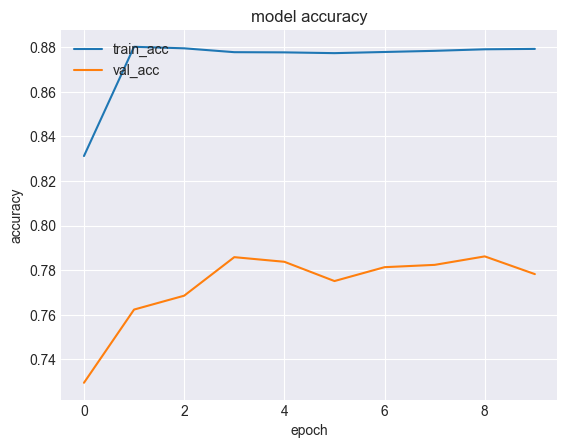

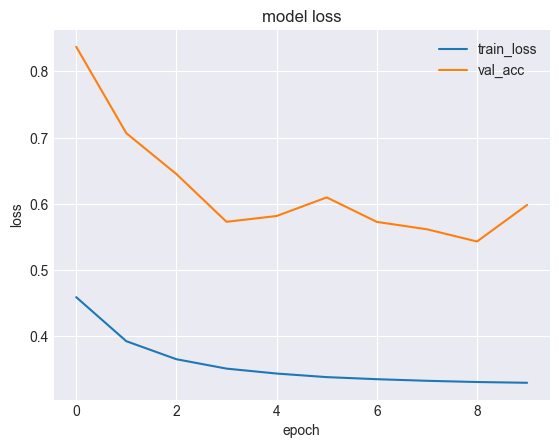

In [381]:
#plot_path = "./figures/"
# list all data in history
#print(class_history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')


#plt.savefig(plot_path+'accuracy.png')
#plt.savefig(plot_path+'accuracy.pdf')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_acc'], loc='upper right')


#plt.savefig(plot_path+'loss.png')
#plt.savefig(plot_path+'loss.pdf')
plt.show()

In [382]:
y_pred = model.predict(X_test)

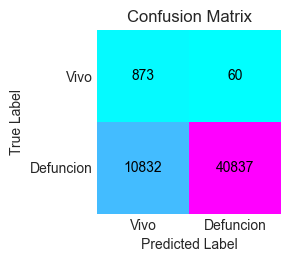

In [383]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, np.argmax(y_pred, axis = 1))

# Create a figure and a single subplot
fig, ax = plt.subplots(1, 1, figsize=(3,3))

# Plot the confusion matrix
im = ax.imshow(confusion_matrix,
               cmap='cool',
               interpolation='nearest')

# Add values inside the cells
for j in range(2):
    for k in range(2):
        ax.text(k, j, str(confusion_matrix[j, k]), ha='center', va='center', color='black')

# Add labels, title, etc.
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
#ax.set_xticks([0, 1,2,3,4, 5, 6, 7,], labels=['Si', 'No', 'Baño', 'Hambre', 'Sed', 'Ayuda', 'Dolor', 'Gracias'])
#ax.set_yticks([0, 1,2,3,4, 5, 6, 7,], labels=['Si', 'No', 'Baño', 'Hambre', 'Sed', 'Ayuda', 'Dolor', 'Gracias'])
ax.set_xticks([0, 1], labels=['Vivo', 'Defuncion'])
ax.set_yticks([0, 1], labels=['Vivo', 'Defuncion'])
ax.xaxis.set_tick_params(labelbottom=True)
ax.yaxis.set_tick_params(labelleft=True)
ax.grid(False)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show plot
plt.show()

In [384]:
class_acc_LSTM = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy (Class Model): {:.2f}%".format(class_acc_LSTM * 100))

Test Accuracy (Class Model): 79.29%


In [385]:
print(classification_report(y_test,
                      np.argmax(y_pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.07      0.94      0.14       933
           1       1.00      0.79      0.88     51669

    accuracy                           0.79     52602
   macro avg       0.54      0.86      0.51     52602
weighted avg       0.98      0.79      0.87     52602


## Optimizar hiperparametros

In [399]:
numero_capas = (1,2,3,4)
cant_neuronas = (2,4,6)
optimizadores = ('adam', 'SGD')
tamano_batch = (8,16,32,64)
learning_rates = (.1, .01, .001, .0001)
list(itertools.product(numero_capas, cant_neuronas, optimizadores, tamano_batch, learning_rates))

[(1, 2, 'adam', 8, 0.1),
 (1, 2, 'adam', 8, 0.01),
 (1, 2, 'adam', 8, 0.001),
 (1, 2, 'adam', 8, 0.0001),
 (1, 2, 'adam', 16, 0.1),
 (1, 2, 'adam', 16, 0.01),
 (1, 2, 'adam', 16, 0.001),
 (1, 2, 'adam', 16, 0.0001),
 (1, 2, 'adam', 32, 0.1),
 (1, 2, 'adam', 32, 0.01),
 (1, 2, 'adam', 32, 0.001),
 (1, 2, 'adam', 32, 0.0001),
 (1, 2, 'adam', 64, 0.1),
 (1, 2, 'adam', 64, 0.01),
 (1, 2, 'adam', 64, 0.001),
 (1, 2, 'adam', 64, 0.0001),
 (1, 2, 'SGD', 8, 0.1),
 (1, 2, 'SGD', 8, 0.01),
 (1, 2, 'SGD', 8, 0.001),
 (1, 2, 'SGD', 8, 0.0001),
 (1, 2, 'SGD', 16, 0.1),
 (1, 2, 'SGD', 16, 0.01),
 (1, 2, 'SGD', 16, 0.001),
 (1, 2, 'SGD', 16, 0.0001),
 (1, 2, 'SGD', 32, 0.1),
 (1, 2, 'SGD', 32, 0.01),
 (1, 2, 'SGD', 32, 0.001),
 (1, 2, 'SGD', 32, 0.0001),
 (1, 2, 'SGD', 64, 0.1),
 (1, 2, 'SGD', 64, 0.01),
 (1, 2, 'SGD', 64, 0.001),
 (1, 2, 'SGD', 64, 0.0001),
 (1, 4, 'adam', 8, 0.1),
 (1, 4, 'adam', 8, 0.01),
 (1, 4, 'adam', 8, 0.001),
 (1, 4, 'adam', 8, 0.0001),
 (1, 4, 'adam', 16, 0.1),
 (1, 4, 'ada

In [404]:
def optimizar_hiperparametros(X_train, y_train, X_test, y_test):
    numero_capas = (1,2,3,4)
    cant_neuronas = (2,4,6)
    optimizadores = ('adam', 'SGD')
    tamano_batch = (8,16,32,64)
    learning_rates = (.1, .01, .001, .0001)
    
    # Dictionary to store parameters and accuracies
    results = []
    
    # Grid Search
    mejor_acc = 0
    mejores_hiperparametros = None
    
    for capas, neuronas, optimizador, batch, lr in tqdm(list(itertools.product(numero_capas, cant_neuronas, optimizadores, tamano_batch, learning_rates))):
        
        model = Sequential()
        model.add(Dense(neuronas, activation='relu', input_shape=(X_resampled.shape[1],)))
        for _ in range(capas - 1):
            model.add(Dense(neuronas, activation='relu'))
        model.add(Dense(2, activation='softmax'))
        
        if optimizador == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=lr)
        elif optimizador == 'SGD':
            opt = tf.keras.optimizers.SGD(learning_rate=lr)

        model.compile(optimizer=opt,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'],
                      )
        
        
        model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=batch,
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              patience=4,
                                                              restore_best_weights=True)],
                  verbose = 0
                  )
        
        acc = model.evaluate(X_test, y_test, verbose=0)[1]
        
        # Store the result
        results.append({
            'capas': capas,
            'neuronas': neuronas,
            'optimizador': optimizador,
            'batch': batch,
            'lr': lr,
            'acc': acc
        })
        
        if acc > mejor_acc:
            mejor_acc = acc
            mejores_hiperparametros = (capas, neuronas, optimizador, batch, lr)
        
    return mejor_acc, mejores_hiperparametros
    

In [405]:
mejor_acc, mejores_hiperparametros = optimizar_hiperparametros(X_resampled, y_resampled, X_test, y_test)

100%|██████████| 384/384 [1:08:20<00:00, 10.68s/it]


In [406]:
print(mejor_acc, mejores_hiperparametros)

0.9570358395576477 (2, 4, 'SGD', 64, 0.0001)
